# Example of fine-tuning

In [1]:
from datasets import load_dataset

ds = load_dataset("merve/vqav2-small", split="validation[:10%]")

In [2]:
1+1

2

In [ ]:
from huggingface_hub import login

login(token="my_hf_token")

In [5]:
from transformers import MllamaForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
import torch

ckpt = "meta-llama/Llama-3.2-11B-Vision"
USE_LORA = True
FREEZE_LLM = False
FREEZE_IMAGE = False

if USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
        use_dora=True, # optional DoRA 
        init_lora_weights="gaussian"
    )

    model = MllamaForConditionalGeneration.from_pretrained(
            ckpt,
            torch_dtype=torch.bfloat16,
            device_map="auto"
    )

    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

elif FREEZE_IMAGE:
    if FREEZE_LLM:
        raise ValueError("You cannot freeze image encoder and text decoder at the same time.")
    model = MllamaForConditionalGeneration.from_pretrained(ckpt,
        torch_dtype=torch.bfloat16, device_map="auto")
    # freeze vision model to save up on compute
    for param in model.vision_model.parameters():
        param.requires_grad = False

elif FREEZE_LLM:
    if FREEZE_IMAGE:
        raise ValueError("You cannot freeze image encoder and text decoder at the same time.")
    model = MllamaForConditionalGeneration.from_pretrained(ckpt,
        torch_dtype=torch.bfloat16, device_map="auto")
    # freeze text model, this is encouraged in paper
    for param in model.language_model.parameters():
        param.requires_grad = False
        
else: # full ft
    model = MllamaForConditionalGeneration.from_pretrained(ckpt,
        torch_dtype=torch.bfloat16, device_map="auto")

processor = AutoProcessor.from_pretrained(ckpt)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

trainable params: 31,416,320 || all params: 10,674,357,795 || trainable%: 0.2943


In [6]:
def process(examples):
    texts = [f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n<|image|>{example['question']} Answer briefly. <|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{example['multiple_choice_answer']}<|eot_id|>" for example in examples]
    images = [[example["image"].convert("RGB")] for example in examples]

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100 
    labels[labels == 128256] = -100 # image token index
    batch["labels"] = labels
    batch = batch.to(torch.bfloat16).to("cuda")

    return batch

In [26]:
def layout_process(examples):
    texts = [
        f"""<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n<|image|> Create a JSON file with a position of each object on an image: 'object_name': ["left_bot_corner": ?, "left_top_corner": ?, "right_bot_corner": ?, "right_top_corner": ?]. <|eot_id|>
            <|start_header_id|>assistant<|end_header_id|>\n\n{example['answer']}<|eot_id|>""" for example in examples]
    images = [[example["image"].convert("RGB")] for example in examples]

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = labels
    batch = batch.to(torch.bfloat16).to("cuda")

    return batch

In [7]:
from transformers import TrainingArguments
args=TrainingArguments(
            num_train_epochs=2,
            remove_unused_columns=False,
            per_device_train_batch_size=1,
            gradient_accumulation_steps=4,
            warmup_steps=2,
            learning_rate=2e-5,
            weight_decay=1e-6,
            adam_beta2=0.999,
            logging_steps=250,
            save_strategy="no",
            optim="adamw_hf",
            push_to_hub=True,
            save_total_limit=1,
            bf16=True,
            output_dir="./lora",
            dataloader_pin_memory=False,
        )

In [8]:
from transformers import Trainer
trainer = Trainer(
        model=model,
        train_dataset=ds,
        data_collator=process,
        args=args
        )

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [9]:
trainer.train()

/home/rodionfa/mambaforge/envs/llava/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.854300
500,0.649000
750,0.575400
1000,0.556800


TrainOutput(global_step=1072, training_loss=0.6518481418268004, metrics={'train_runtime': 5883.8797, 'train_samples_per_second': 0.729, 'train_steps_per_second': 0.182, 'total_flos': 6703949303393568.0, 'train_loss': 0.6518481418268004, 'epoch': 2.0})

In [16]:
example = ds[0]
input_batch = process([example])
model.eval()
output = model(**input_batch)
print(output)

CausalLMOutputWithPast(loss=tensor(0.4539, device='cuda:0', grad_fn=<ToCopyBackward0>), logits=tensor([[[-7.4062, -2.1562,  1.1484,  ...,  8.9375,  8.9375,  8.9375],
         [-7.4062, -2.1562,  1.1484,  ...,  8.9375,  8.9375,  8.9375],
         [-0.4180,  0.6875,  0.0454,  ...,  1.3906,  1.3906,  1.3906],
         ...,
         [ 3.3125,  5.1250, -0.4102,  ...,  3.2500,  3.2500,  3.2500],
         [ 4.6250,  7.0312, -0.6992,  ...,  4.2500,  4.2500,  4.2500],
         [-8.1250,  0.3047, -7.7500,  ...,  8.6250,  8.6250,  8.6250]]],
       device='cuda:0', grad_fn=<ToCopyBackward0>), past_key_values=None, hidden_states=None, attentions=None)


In [18]:
generated_text = processor.decode(output.logits[0].argmax(dim=-1), skip_special_tokens=True)
print(generated_text)

user

WhatWhat are the children?? Answer briefly. assistant

carnival


In [17]:
prompt = """
<|begin_of_text|><|start_header_id|>user<|end_header_id|>  
<|text|>You are a 3D indoor scene designer.  
Instruction: synthesize the 3D layout of an indoor scene. The generated 3D layout should follow the CSS style, where each line starts with the furniture category and is followed by the 3D size, orientation, and absolute position. Formally, each line should follow the template:  
FURNITURE {length: ?px; width: ?px; height: ?px; orientation: ? degrees; left: ?px; top: ?px; depth: ?px;}  
All values are in pixels, but the orientation angle is in degrees.  

Available furniture: armchair, bookshelf, cabinet, ceiling_lamp, chair, children_cabinet, coffee_table, desk, double_bed, dressing_chair, dressing_table, floor_lamp, kids_bed, nightstand, pendant_lamp, shelf, single_bed, sofa, stool, table, tv_stand, wardrobe.  
Overall furniture frequencies: (armchair: 0.0049; bookshelf: 0.0077; cabinet: 0.0222; ceiling_lamp: 0.0616; chair: 0.0247; children_cabinet: 0.0072; coffee_table: 0.0011; desk: 0.0171; double_bed: 0.1675; dressing_chair: 0.006; dressing_table: 0.021; floor_lamp: 0.0093; kids_bed: 0.0077; nightstand: 0.2655; pendant_lamp: 0.1251; shelf: 0.0086; single_bed: 0.0215; sofa: 0.0019; stool: 0.0117; table: 0.0209; tv_stand: 0.0315; wardrobe: 0.1555).  

Example 1:  
Room Type: bedroom  
Room Size: max length 260px, max width 256px  

Layout:  
double_bed {length: 169px; width: 162px; height: 95px; left: 84px; top: 115px; depth: 47px; orientation: 90 degrees;}  
wardrobe {length: 122px; width: 24px; height: 175px; left: 90px; top: 235px; depth: 87px; orientation: -180 degrees;}  
nightstand {length: 35px; width: 30px; height: 37px; left: 10px; top: 20px; depth: 18px; orientation: 90 degrees;}  
pendant_lamp {length: 34px; width: 31px; height: 95px; left: 17px; top: 32px; depth: 142px; orientation: 0 degrees;}  

Example 2:  
Room Type: bedroom  
Room Size: max length 273px, max width 256px  

Layout:  
double_bed {length: 175px; width: 184px; height: 59px; left: 120px; top: 93px; depth: 29px; orientation: 0 degrees;}  
cabinet {length: 76px; width: 40px; height: 72px; left: 117px; top: 235px; depth: 36px; orientation: 180 degrees;}  
nightstand {length: 43px; width: 30px; height: 61px; left: 22px; top: 16px; depth: 30px; orientation: 0 degrees;}  
shelf {length: 23px; width: 23px; height: 84px; left: 19px; top: 240px; depth: 42px; orientation: 0 degrees;}  
pendant_lamp {length: 50px; width: 46px; height: 65px; left: 121px; top: 143px; depth: 166px; orientation: 0 degrees;}<|eot_id|>
"""

In [18]:
# prompt = ""
inputs = processor(text=prompt, images=None, return_tensors="pt").to("cuda")
output = model.generate(**inputs, max_new_tokens=750)
generated_text = processor.decode(output[0], skip_special_tokens=True)
print(generated_text)


user  
<|text|>You are a 3D indoor scene designer.  
Instruction: synthesize the 3D layout of an indoor scene. The generated 3D layout should follow the CSS style, where each line starts with the furniture category and is followed by the 3D size, orientation, and absolute position. Formally, each line should follow the template:  
FURNITURE {length:?px; width:?px; height:?px; orientation:? degrees; left:?px; top:?px; depth:?px;}  
All values are in pixels, but the orientation angle is in degrees.  

Available furniture: armchair, bookshelf, cabinet, ceiling_lamp, chair, children_cabinet, coffee_table, desk, double_bed, dressing_chair, dressing_table, floor_lamp, kids_bed, nightstand, pendant_lamp, shelf, single_bed, sofa, stool, table, tv_stand, wardrobe.  
Overall furniture frequencies: (armchair: 0.0049; bookshelf: 0.0077; cabinet: 0.0222; ceiling_lamp: 0.0616; chair: 0.0247; children_cabinet: 0.0072; coffee_table: 0.0011; desk: 0.0171; double_bed: 0.1675; dressing_chair: 0.006; dre

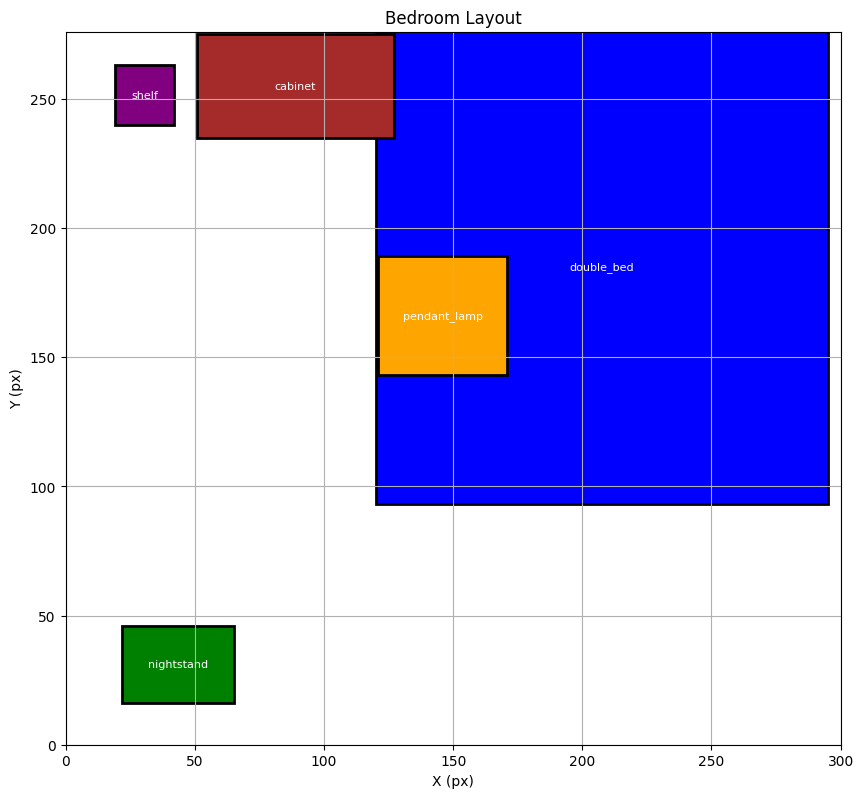

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Room dimensions
room_length = 300
room_width = 276

# Define furniture items
furniture = [
    {"name": "double_bed", "length": 175, "width": 184, "left": 120, "top": 93, "color": "blue"},
    {"name": "cabinet", "length": 76, "width": 40, "left": 51, "top": 235, "color": "brown"},
    {"name": "nightstand", "length": 43, "width": 30, "left": 22, "top": 16, "color": "green"},
    {"name": "shelf", "length": 23, "width": 23, "left": 19, "top": 240, "color": "purple"},
    {"name": "pendant_lamp", "length": 50, "width": 46, "left": 121, "top": 143, "color": "orange"},
]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Draw room boundary
ax.set_xlim(0, room_length)
ax.set_ylim(0, room_width)
ax.set_aspect('equal')
ax.set_title("Bedroom Layout")
ax.set_xlabel("X (px)")
ax.set_ylabel("Y (px)")

# Draw furniture
for item in furniture:
    rect = patches.Rectangle(
        (item["left"], item["top"]), item["length"], item["width"],
        linewidth=2, edgecolor='black', facecolor=item["color"]
    )
    ax.add_patch(rect)
    plt.text(
        item["left"] + item["length"] / 2,
        item["top"] + item["width"] / 2,
        item["name"], ha="center", va="center", fontsize=8, color="white"
    )

# Add grid and show plot
plt.grid(True)
plt.show()


In [ ]:
# prompt = ""
inputs = processor(text=prompt, images=None, return_tensors="pt").to("cuda")
output = model.generate(**inputs, max_new_tokens=750)
generated_text = processor.decode(output[0], skip_special_tokens=True)
print(generated_text)


user
<|text|>You are a 3D indoor scene designer. 
Instruction: synthesize the 3D layout of an indoor scene. The generated 3D layout should follow the CSS style, where each line starts with the furniture category and is followed by the 3D size, orientation and absolute position. Formally, each line should follow the template: 
FURNITURE {length:?px: width:?px; height:?px; orientation:? degrees; left:?px; top:?px; depth:?px;}
All values are in pixel but the orientation angle is in degrees.

Available furnitures: armchair, bookshelf, cabinet, ceiling_lamp, chair, children_cabinet, coffee_table, desk, double_bed, dressing_chair, dressing_table, floor_lamp, kids_bed, nightstand, pendant_lamp, shelf, single_bed, sofa, stool, table, tv_stand, wardrobe
Overall furniture frequencies: (armchair: 0.0049; bookshelf: 0.0077; cabinet: 0.0222; ceiling_lamp: 0.0616; chair: 0.0247; children_cabinet: 0.0072; coffee_table: 0.0011; desk: 0.0171; double_bed: 0.1675; dressing_chair: 0.006; dressing_table: 

In [ ]:
model()